<a href="https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/BScThesis_model_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('BScThesis/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip3 install torch torchvision

In [4]:
!git clone https://github.com/wiatrak2/BScThesis

Cloning into 'BScThesis'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 134 (delta 71), reused 68 (delta 28), pack-reused 0
Receiving objects: 100% (134/134), 6.69 MiB | 14.80 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [0]:
from importlib import reload 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict, namedtuple
import copy

In [0]:
from mnist_m import Mnist_M
from datasets_merge import Merge_Datasets
import models
import trainer
import domain_trainer
from test_model import test_model
import plots
import test

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=128
num_workers=1

In [12]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



Processing...
Done!


In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.001
momentum=0.9

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize(3*[0.1307], 3*[0.3081]),
                       ])
mnist_m_train = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',
                        transform=mnist_m_transform)
mnist_m_test = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



In [0]:
Models = namedtuple('Models', ['model_f', 'model_c', 'model_d'])
Optims = namedtuple('Optims', ['optim_f', 'optim_c', 'optim_d'])
Criterions = namedtuple('Criterions', ['criterion', 'criterion_domain'])
Loaders = namedtuple('Loaders', ['train_loader', 'train_loader_domain',
                                'source_test_loader', 'target_test_loader',
                                'merged_test_loader'])

In [0]:
mnist_ext_train = Merge_Datasets([train_set, mnist_m_train])
mnist_ext_test = Merge_Datasets([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)




In [0]:
loaders = Loaders(train_loader, mnist_m_train_loader,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader)

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
criterions = Criterions(criterion, criterion_domain)

In [0]:
epochs=4

In [0]:
model_f_size = [[320, 240], [320, 160], [320, 120]]
model_c_size = [[240, 100], [160, 100], [120, 60]]
model_d_size = [[240, 100], [160, 100], [120, 60]]

In [93]:
trainers=[]
test_histories=[]
for mf, mc, md in list(zip(model_f_size, model_c_size, model_d_size)):
  model_f, model_c, model_d = models.get_models(mf, mc, md,
                                             use_gr=True, model_f_dropout=True)

  model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)
  optim_f = optim.Adam(model_f.parameters(), lr=lr)
  optim_c = optim.Adam(model_c.parameters(), lr=lr)
  optim_d = optim.Adam(model_d.parameters(), lr=lr)
  train_models = Models(model_f, model_c, model_d)
  optims = Optims(optim_f, optim_c, optim_d)
  trainers.append(trainer.Trainer(train_models, optims, criterions, device,
                                tune_lr=True))
  test_histories.append(defaultdict(lambda:[]))
  trainers[-1].train(2, loaders, test_history=test_histories[-1])

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.336768, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.495409, lr: 0.00580 lambd: 0.48792
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.262064, lr: 0.00425 lambd: 0.78820
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.374382, lr: 0.00341 lambd: 0.92167
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.224666, lr: 0.00288 lambd: 0.97233

Target Domain Test set: Average loss: 1.7963, Accuracy: 5714/10000 (57%)

Source Domain Test set: Average loss: 0.0974, Accuracy: 9723/10000 (97%)

Domains predictor:  Accuracy: 14342/20000 (72%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.343520, lr: 0.00261 lambd: 0.98661
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.239512, lr: 0.00231 lambd: 0.99537
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.381753, lr: 0.00208 lambd: 0.99841
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.206363, lr: 0.00189 lambd: 0.99945
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.103809, lr: 0.001

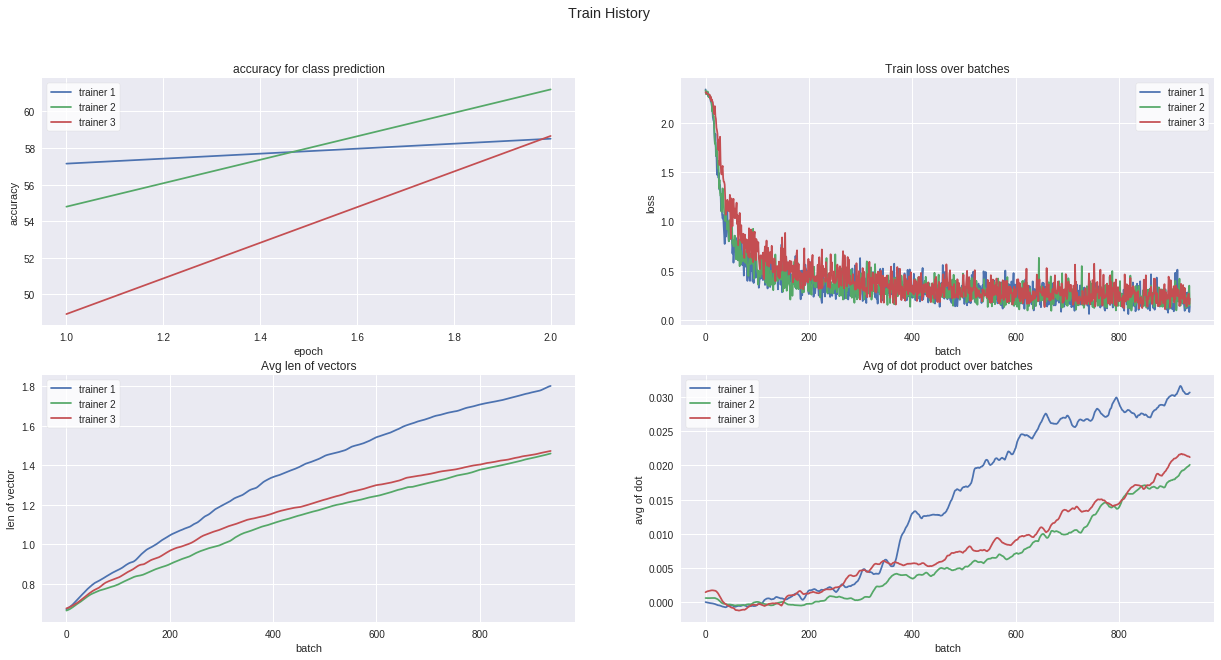

In [94]:
plots.plot_multimodel_stats(trainers, test_histories)

In [95]:
model_f

Sequential(
  (0): MnistFeatureExtractor(
    (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5)
  )
  (1): LinearFromList(
    (linears): ModuleList(
      (0): Linear(in_features=320, out_features=120, bias=True)
    )
  )
)

In [96]:
model_c

Sequential(
  (0): LinearFromList(
    (linears): ModuleList(
      (0): Linear(in_features=120, out_features=60, bias=True)
    )
  )
  (1): Linear(in_features=60, out_features=10, bias=True)
  (2): LogSoftmax()
)

In [97]:
model_d

LinearFromList(
  (linears): ModuleList()
  (output_model): DomainPredictor(
    (fc1): Linear(in_features=120, out_features=60, bias=True)
    (fc2): Linear(in_features=60, out_features=2, bias=True)
  )
)